<a href="https://colab.research.google.com/github/jiwoong2/deeplearning/blob/main/torch_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

## STEP 1. 데이터 만들기

In [17]:
# # case 1 키, 몸무게
# N=20
# random0=torch.randn(int(N/2),1)
# random5=torch.randn(int(N/2),1)+5
# class1_data=torch.hstack([random0,random5])
# class2_data=torch.hstack([random5,random0])
# class1_label=torch.ones(int(N/2),1)
# class2_label=torch.zeros(int(N/2),1)
# X=torch.vstack([class1_data,class2_data])
# y=torch.vstack([class1_label,class2_label])

# case 2
N=100
radius1=0.3+0.05*torch.randn(int(N/2),1)
radius2=1+0.01*torch.randn(int(N/2),1)
theta1=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
theta2=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
class1_data=torch.hstack([radius1*torch.cos(theta1), radius1*torch.sin(theta1)])
class2_data=torch.hstack([radius2*torch.cos(theta2), radius2*torch.sin(theta2)])
class1_label=torch.ones(int(N/2),1)
class2_label=torch.zeros(int(N/2),1)
X=torch.vstack([class1_data,class2_data])
y=torch.vstack([class1_label,class2_label])

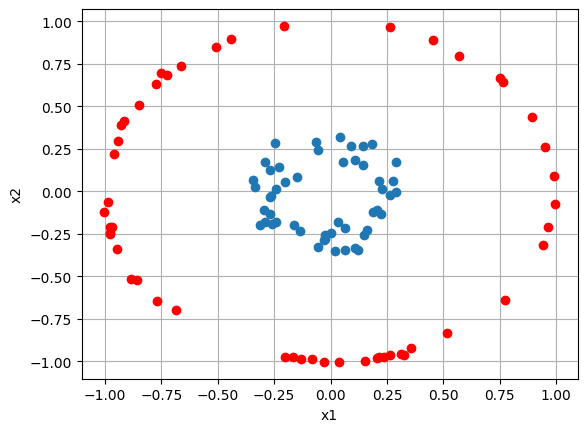

In [18]:
import matplotlib.pyplot as plt
plt.plot(class1_data[:,0],class1_data[:,1],'o')
plt.plot(class2_data[:,0],class2_data[:,1],'ro')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

## STEP 2. 모델 만들기

In [19]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # case 1, plain 히든레이어가 1개
        self.linear = nn.Sequential(nn.Linear(2, 100), # 1000,10000으로 바꿔보면서 3d그래프의 변화 관찰.
                                    nn.Sigmoid(),
                                    nn.Linear(100, 1),
                                    nn.Sigmoid())

        # # case 1, very simple  # 꽤 괜찮게 학습함. 무조건 모델의 복잡할수록 좋은건 아님.
        # self.linear = nn.Sequential(nn.Linear(2, 1),
        #                             nn.Sigmoid())

        # # case 1, deep # 파라미터가 너무 많으면 학습하는데 오래걸림 epoch이 많이 필요하고 학습이 느림.
                         # 제한된 epoch에서 학습하고(너무 오래 걸려서) 싶다면 optimizer을 바꿔보자
        # self.linear = nn.Sequential(nn.Linear(2, 100),
        #                             nn.Sigmoid(),
        #                             nn.Linear(100, 100),
        #                             nn.Sigmoid(),
        #                             nn.Linear(100, 100),
        #                             nn.Sigmoid(),
        #                             nn.Linear(100, 1),
        #                             nn.Sigmoid())

        # # case 2, plain
        # self.linear = nn.Sequential(nn.Linear(2, 100),
        #                             nn.Sigmoid(),
        #                             nn.Linear(100, 1),
        #                             nn.Sigmoid())

        # # case 2, very simple
        # self.linear = nn.Sequential(nn.Linear(2, 1),
        #                             nn.Sigmoid())

        # # case 2, deep
        # self.linear = nn.Sequential(nn.Linear(2, 100),
        #                             nn.Sigmoid(),
        #                             nn.Linear(100, 100),
        #                             nn.Sigmoid(),
        #                             nn.Linear(100, 100),
        #                             nn.Sigmoid(),
        #                             nn.Linear(100, 1),
        #                             nn.Sigmoid())

        # # case 2, very deep
        # self.linear = nn.Sequential(nn.Linear(2, 100),
        #                             nn.Sigmoid(),
        #                             nn.Sequential(*[i for _ in range(10) for i in [nn.Linear(100,100), nn.Sigmoid()]]),
        #                             nn.Linear(100, 1),
        #                             nn.Sigmoid())

        # # case 2, very deep, relu
        # self.linear = nn.Sequential(nn.Linear(2, 100),
        #                             nn.ReLU(),
        #                             nn.Sequential(*[i for _ in range(10) for i in [nn.Linear(100,100), nn.ReLU()]]),
        #                             nn.Linear(100, 1),
        #                             nn.Sigmoid())

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
# nn.Sequential(*[nn.Sequential(nn.Linear(100,100), nn.Sigmoid()) for _ in range(5)])
# nn.Sequential(*[nn.Linear(100,100) if i % 2 == 0 else nn.Sigmoid() for i in range(10)])
# nn.Sequential(*[i for _ in range(5) for i in [nn.Linear(100,100), nn.Sigmoid()]])

In [24]:
model = MLP()
print(model)
print(model(torch.randn(5,2)).shape) # 2개 값으로 이루어진 좌표값 (x1,x2) 데이터 5개를 입력함

MLP(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
torch.Size([5, 1])


## STEP 3. 모델 학습시키기

In [25]:
from torch import optim
import torch.nn.functional as F

LR = 1e-1 # case 1
# LR = 1e-2 # case 2, plain 에서 노드 천 개, deep 발산. 초반에 loss그래프가 튈때, 파라미터가 많을때는 러닝레이트를 줄여보자.
# LR = 1e-4 # case 2, very deep relu
EPOCH = 100 # case 1
# EPOCH = 500 # case 2, plain 에서 노드 천 개, deep, very deep relu

# optimizer = optim.SGD(model.parameters(), lr=LR) # 모델의 모든 파라미터와 러닝레이트를 입력.
optimizer = optim.Adam(model.parameters(), lr=LR) # case 1, deep

loss_history =[]

model.train() # train mode로 전환
for ep in range(EPOCH):
    # inference
    y_hat = model(X)
    # loss
    loss = F.binary_cross_entropy(y_hat, y) # 순서 중요
    # update
    optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
    loss.backward() # backpropagation
    optimizer.step() # weight update
    # print loss
    loss_history += [loss.item()]
    print(f"Epoch: {ep+1}, train loss: {round(loss.item(),3)}")
    print("-"*20)

Epoch: 1, train loss: 0.694
--------------------
Epoch: 2, train loss: 1.36
--------------------
Epoch: 3, train loss: 0.832
--------------------
Epoch: 4, train loss: 1.098
--------------------
Epoch: 5, train loss: 0.77
--------------------
Epoch: 6, train loss: 0.742
--------------------
Epoch: 7, train loss: 0.915
--------------------
Epoch: 8, train loss: 0.825
--------------------
Epoch: 9, train loss: 0.682
--------------------
Epoch: 10, train loss: 0.729
--------------------
Epoch: 11, train loss: 0.808
--------------------
Epoch: 12, train loss: 0.764
--------------------
Epoch: 13, train loss: 0.68
--------------------
Epoch: 14, train loss: 0.68
--------------------
Epoch: 15, train loss: 0.731
--------------------
Epoch: 16, train loss: 0.735
--------------------
Epoch: 17, train loss: 0.687
--------------------
Epoch: 18, train loss: 0.654
--------------------
Epoch: 19, train loss: 0.67
--------------------
Epoch: 20, train loss: 0.692
--------------------
Epoch: 21, tra

In [8]:
x= torch.tensor([1.],requires_grad=True)
for _ in range(3):  # backward가 누적됨.
    loss=x**2
    loss.backward()
    print(x.grad)
    #x.grad = None # 누적을 방지하기위해 초기화

tensor([2.])
tensor([4.])
tensor([6.])


In [ ]:
print(F.binary_cross_entropy(y_hat,y))
print(-torch.sum(torch.log(y_hat**y*(1-y_hat)**(1-y)))/N) # 각 데이터에 대해 바이너리 크로스엔트로피를 구한후 평균.

tensor(7.8607e-06, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(7.8607e-06, grad_fn=<DivBackward0>)


Text(0, 0.5, 'loss')

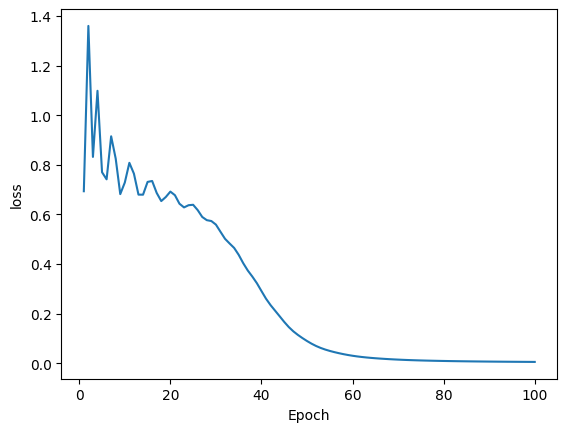

In [26]:
plt.plot(range(1,EPOCH+1),loss_history)
plt.xlabel('Epoch')
plt.ylabel('loss')

## STEP 4. 모델 테스트하기

Text(0.5, 0.5, 'x2')

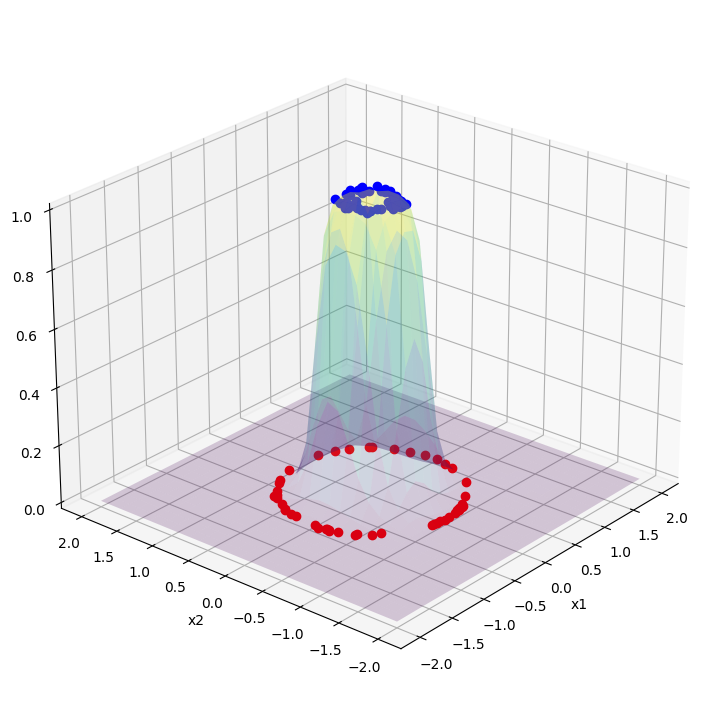

In [28]:
# x1_test=torch.linspace(-10,10,30) # case 1
# x2_test=torch.linspace(-10,10,30) # case 1

x1_test=torch.linspace(-2,2,30) # case 2
x2_test=torch.linspace(-2,2,30) # case 2

X1_test, X2_test=torch.meshgrid(x1_test,x2_test)
X_test=torch.cat([X1_test.unsqueeze(dim=2), X2_test.unsqueeze(dim=2)], dim=2)

model.eval() # test mode로 # 1. dropout 혹은 BN 같은거 사용했다면 train mode와 test mode 동작이 다르므로 eval()로 mode를 바꿔줘야

with torch.no_grad(): # 2. grad_fn 계산 <- 메모리가 불필요하게 쓰인다
    y_hat = model(X_test)

Y_hat = y_hat.squeeze()

# print(model.training)
# model.train()
# print(model.training)

plt.figure(figsize=[10, 9]) # figsize=[가로, 세로]
ax = plt.axes(projection="3d")
ax.view_init(elev=25,azim=-140)
ax.plot_surface(X1_test,X2_test, Y_hat.numpy(), cmap="viridis", alpha=0.2)
plt.plot(class1_data[:,0],class1_data[:,1],class1_label.squeeze(),'bo')
plt.plot(class2_data[:,0],class2_data[:,1],class2_label.squeeze(),'ro')
plt.xlabel("x1")
plt.ylabel("x2")

In [29]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=X1_test, y=X2_test, z=Y_hat, colorscale="viridis", opacity=0.5)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title='binary classification', width=700, height=600)